## Demo #4: Forecasting with cutomized dependencies

## Import libraries

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pytagi import Normalizer
import pytagi.metric as metric
import copy

## Import components

In [2]:
from canari.data_process import DataProcess
from canari.baseline_component import LocalTrend
from canari.white_noise_component import WhiteNoise
from canari.model import Model
from canari.lstm_component import LstmNetwork
from canari.data_visualization import (
    plot_data,
    plot_prediction,
    plot_states,
)

## Read data

In [3]:
data_file = "/Users/vuongdai/GitHub/canari/data/benchmark_data/test_4_data.csv"
df = pd.read_csv(data_file, skiprows=1, delimiter=",", header=None)
time = pd.to_datetime(df.iloc[:, 0])
df = df.iloc[:, 1:]
df.index = time
df.index.name = "time"
df.columns = ["crack opening", "water_level", "temp_min", "temp_max"]
df.head()

,crack opening,water_level,temp_min,temp_max
time,,,,
2010-11-07,6.595455,31.053636,-2.2,3.5
2010-11-14,6.523333,30.986667,-1.7,9.9
2010-11-21,6.430000,31.070000,-5.8,1.6
2010-11-28,6.360000,31.000000,-11.5,0.1
2010-12-05,6.210000,30.930000,-5.1,-1.1


## Plot data

Text(0, 0.5, 'temp. max')

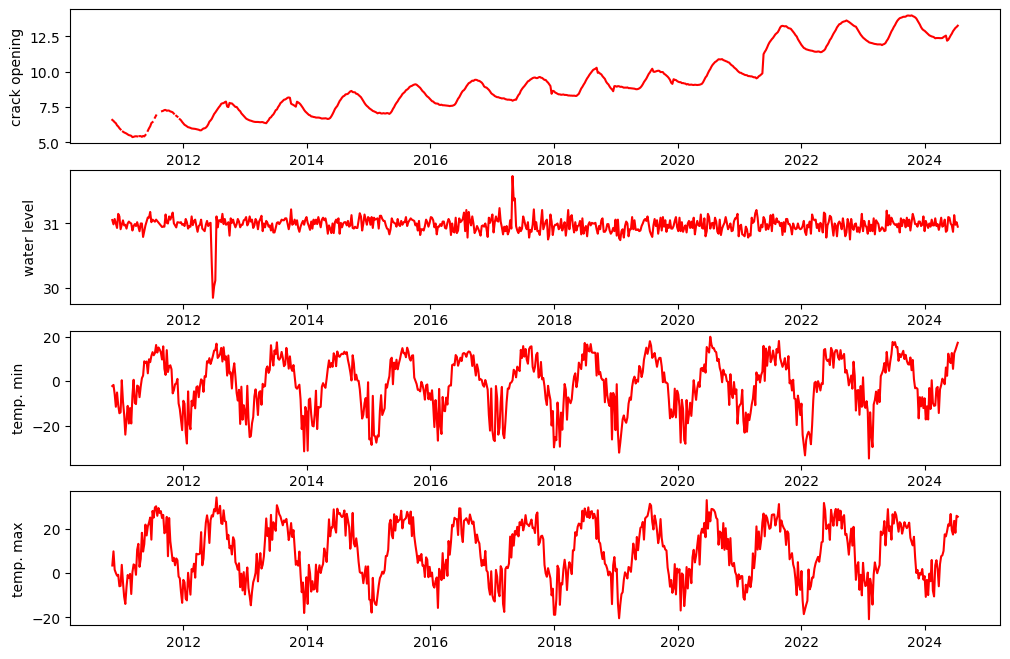

In [4]:
fig,ax = plt.subplots(4,1,figsize=(12, 8))
ax[0].plot(df.index, df.values[:,0], color="r")
ax[0].set_ylabel("crack opening")
ax[1].plot(df.index, df.values[:,1], color="r")
ax[1].set_ylabel("water level")
ax[2].plot(df.index, df.values[:,2], color="r")
ax[2].set_ylabel("temp. min")
ax[3].plot(df.index, df.values[:,3], color="r")
ax[3].set_ylabel("temp. max")


### Customize dependencies:
- #### Lagged values
- #### Moving averages

In [5]:
lags = [0, 1, 2, 1]
df_lag = DataProcess.add_lagged_columns(df, lags)
df_lag.head()

,crack opening,water_level,water_level_lag1,temp_min,temp_min_lag1,temp_min_lag2,temp_max,temp_max_lag1
time,,,,,,,,
2010-11-07,6.595455,31.053636,0.000000,-2.2,0.0,0.0,3.5,0.0
2010-11-14,6.523333,30.986667,31.053636,-1.7,-2.2,0.0,9.9,3.5
2010-11-21,6.430000,31.070000,30.986667,-5.8,-1.7,-2.2,1.6,9.9
2010-11-28,6.360000,31.000000,31.070000,-11.5,-5.8,-1.7,0.1,1.6
2010-12-05,6.210000,30.930000,31.000000,-5.1,-11.5,-5.8,-1.1,0.1


In [6]:
df_lag['MA_temp_max'] =  df_lag['temp_max'].rolling(window=3).mean()
df_lag.head()

,crack opening,water_level,water_level_lag1,temp_min,temp_min_lag1,temp_min_lag2,temp_max,temp_max_lag1,MA_temp_max
time,,,,,,,,,
2010-11-07,6.595455,31.053636,0.000000,-2.2,0.0,0.0,3.5,0.0,NaN
2010-11-14,6.523333,30.986667,31.053636,-1.7,-2.2,0.0,9.9,3.5,NaN
2010-11-21,6.430000,31.070000,30.986667,-5.8,-1.7,-2.2,1.6,9.9,5.000000
2010-11-28,6.360000,31.000000,31.070000,-11.5,-5.8,-1.7,0.1,1.6,3.866667
2010-12-05,6.210000,30.930000,31.000000,-5.1,-11.5,-5.8,-1.1,0.1,0.200000


## Data preprocess

In [7]:
output_col = [0]
data_processor = DataProcess(
    data=df_lag,
    time_covariates=["week_of_year"],
    train_split=0.4,
    validation_split=0.07,
    output_col=output_col,
)
train_data, validation_data, test_data, normalized_data = data_processor.get_splits()


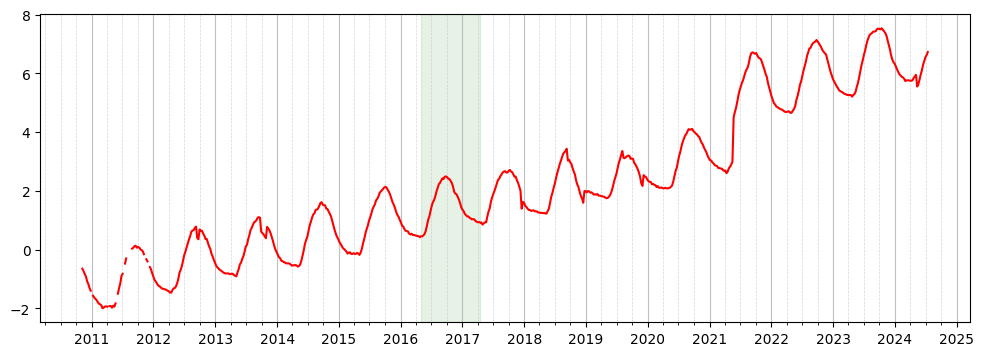

In [8]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_data(
    data_processor=data_processor,
    normalization=True,
    plot_test_data=True,
    plot_column=output_col,
    validation_label="y",
)

## Define model from components

In [9]:
local_trend = LocalTrend()
pattern = LstmNetwork(
        look_back_len=14,
        num_features=10, # number of data's columns + time covariates
        num_layer=1,
        num_hidden_unit=50,
        device="cpu",
        manual_seed=1,
    )
residual = WhiteNoise(std_error=0.04168)

model = Model(local_trend, pattern, residual)

## Train model -- Objective: train LSTM neural network -- model.lstm_train()

In [10]:
model.auto_initialize_baseline_states(train_data["y"][0 : 52 * 3])
max_num_epoch = 50
states_optim = None
mu_validation_preds_optim = None
std_validation_preds_optim = None

for epoch in range(max_num_epoch):
    mu_validation_preds, std_validation_preds, states = model.lstm_train(
        train_data=train_data,
        validation_data=validation_data,
    )

    mu_validation_preds_unnorm = Normalizer.unstandardize(
        mu_validation_preds,
        data_processor.norm_const_mean[data_processor.output_col],
        data_processor.norm_const_std[data_processor.output_col],
    )

    std_validation_preds_unnorm = Normalizer.unstandardize_std(
        std_validation_preds,
        data_processor.norm_const_std[data_processor.output_col],
    )

    validation_obs = data_processor.get_data("validation").flatten()
    validation_log_lik = metric.log_likelihood(
        prediction=mu_validation_preds_unnorm,
        observation=validation_obs,
        std=std_validation_preds_unnorm,
    )

    model.early_stopping(evaluate_metric=-validation_log_lik, mode="min")

    if epoch == model.optimal_epoch:
        mu_validation_preds_optim = mu_validation_preds.copy()
        std_validation_preds_optim = std_validation_preds.copy()
        states_optim = copy.copy(states)
    if model.stop_training:
        break

## Learning's curve

Optinal epoch       : 19
Validation MSE      :-0.8659


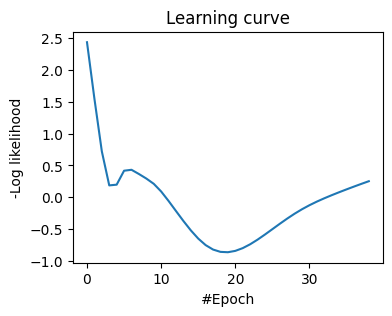

In [11]:
fig,ax = plt.subplots(figsize=(4,3))
plt.plot(model.early_stop_metric_history)
ax.set_ylabel("-Log likelihood")
ax.set_xlabel("#Epoch")
plt.title("Learning curve")
print(f"Optinal epoch       : {model.optimal_epoch}")
print(f"Validation MSE      :{model.early_stop_metric: 0.4f}")

## Plot predictions and hidden states

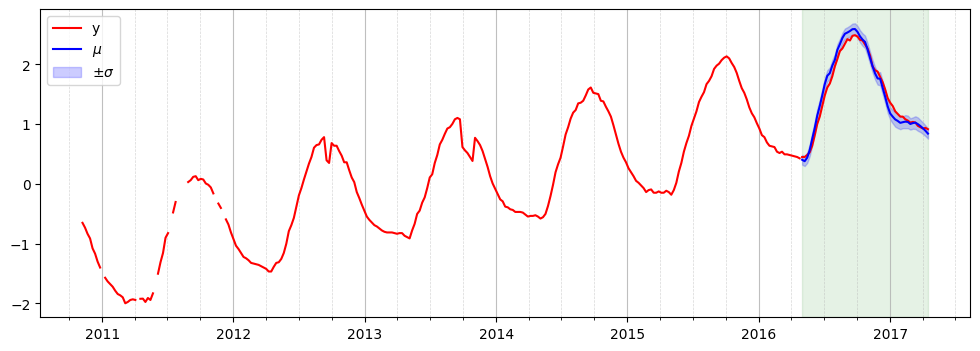

In [12]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_data(
    data_processor=data_processor,
    normalization=True,
    plot_test_data=False,
    plot_column=output_col,
    validation_label="y",
)
plot_prediction(
    data_processor=data_processor,
    mean_validation_pred=mu_validation_preds_optim,
    std_validation_pred=std_validation_preds_optim,
    validation_label=[r"$\mu$", f"$\pm\sigma$"],
)
plt.legend()
plt.show()

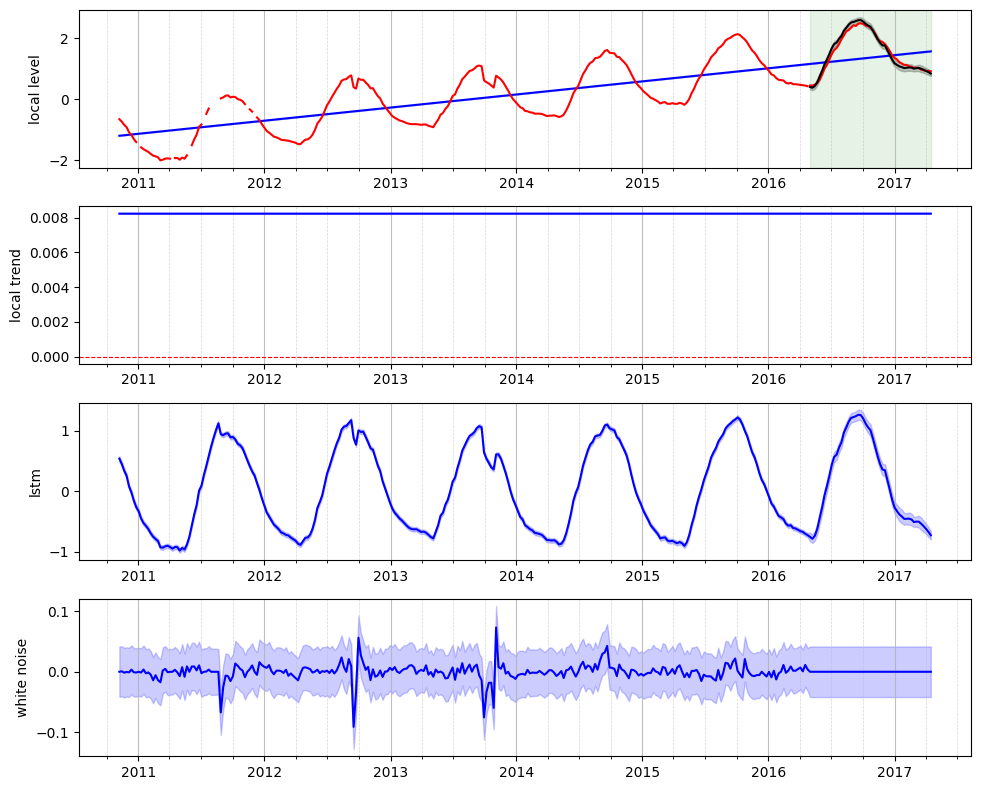

In [13]:
fig, ax =plot_states(
        data_processor=data_processor,
        normalization=True,
        states=states_optim,
        states_to_plot=["local level", "local trend", "lstm", "white noise"],
        )
plot_data(
        data_processor=data_processor,
        normalization=True,
        plot_test_data=False,
        sub_plot=ax[0]
        )
plot_prediction(
        data_processor=data_processor,
        mean_validation_pred=mu_validation_preds_optim,
        std_validation_pred = std_validation_preds_optim,
        sub_plot=ax[0],
        color="k",
        )
plt.show()